100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Using device: cuda

Epoch [1/5] Results
  - Average Total Loss: 282.9371
  - Average Reconstruction Loss: 234.9127
  - Average KL Divergence: 48.0244
  - Average Log Probability (log_px): 63.6655
  - Elapsed Time: 14.36 seconds

Model saved at epoch 1. Best Loss: 282.9371

Epoch [2/5] Results
  - Average Total Loss: 195.0021
  - Average Reconstruction Loss: 149.9837
  - Average KL Divergence: 45.0184
  - Average Log Probability (log_px): 59.3088
  - Elapsed Time: 14.14 seconds

Model saved at epoch 2. Best Loss: 195.0021

Epoch [3/5] Results
  - Average Total Loss: 173.8788
  - Average Reconstruction Loss: 127.0207
  - Average KL Divergence: 46.8581
  - Average Log Probability (log_px): 61.9575
  - Elapsed Time: 14.23 seconds

Model saved at epoch 3. Best Loss: 173.8788

Epoch [4/5] Results
  - Average Total Loss: 158.9014
  - Average Reconstruction Loss: 112.0850
  - Average KL Divergence: 46.8164

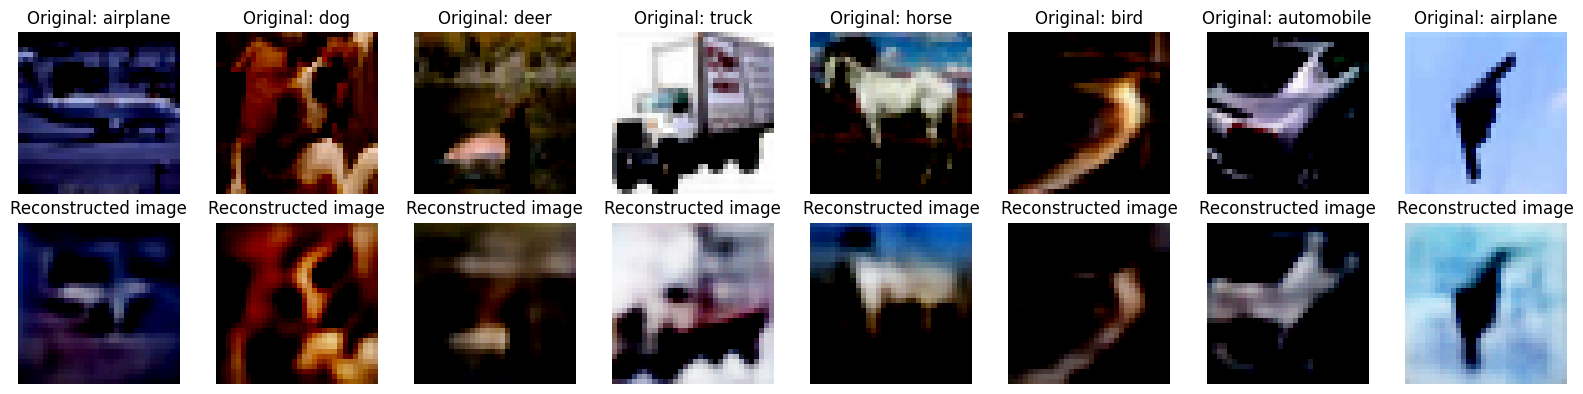

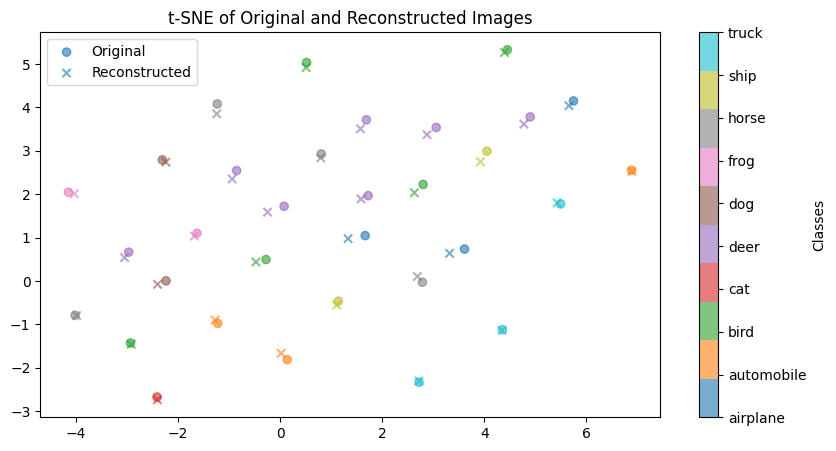

Test Loss: 137.1068
Training completed and model saved. Test Loss: 137.1068
Reconstruction images saved as 'reconstructions.png'.


In [1]:
import numpy as np
import time
import os

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch.optim as optim
from torch.distributions import Normal

from modules import VAE
from utils import visualize_vqreconstruction, visualize_vqtsne

# Custom criterion definition using F.mse_loss
def criterion(x_tilde, x):
    """
    Compute the reconstruction loss using Mean Squared Error (MSE).

    Args:
    - x_tilde: Reconstructed image from the VAE model.
    - x: Original image.

    Returns:
    - loss: Mean Squared Error loss for the reconstruction.
    """
    return F.mse_loss(x_tilde, x, reduction='sum') / x.size(0)

# Train function for VAE
def train(model, optimizer, train_loader, device, train_dataset, num_epochs=20, save_dir='./models', model_name='vae_model'):
    """
    Train the VAE model.

    Args:
    - model: VAE model (initialized)
    - optimizer: optimizer for VAE model
    - train_loader: DataLoader for training data
    - device: device to perform computation (cpu or cuda)
    - train_dataset: training dataset for visualization
    - num_epochs: number of epochs to train (default: 20)
    - save_dir: directory to save the model (default: './models')
    - model_name: name of the model file (default: 'vae_model')
    """
    os.makedirs(save_dir, exist_ok=True)  # Create save directory if it does not exist

    best_loss = float('inf')  # Track the best loss
    last_saved = -1  # Track the last saved epoch

    model.train()
    for epoch in range(num_epochs):
        train_loss = 0.0
        total_reconstruction_loss = 0.0  # Initialize total reconstruction loss
        total_kl_div = 0.0  # Initialize total KL divergence
        total_log_px = 0.0  # Initialize total log probability
        start_time = time.time()  # Record the start time

        for batch_idx, (images, _) in enumerate(train_loader):
            images = images.to(device)

            # Forward pass: VAE reconstruction
            x_tilde, kl_div = model(images)

            # Compute losses
            loss_recons = criterion(x_tilde, images)  # Reconstruction loss
            total_loss = loss_recons + kl_div  # Combined loss

            # Compute log probability (similar to the second code)
            nll = -Normal(x_tilde, torch.ones_like(x_tilde)).log_prob(images)
            log_px = nll.mean().item() - np.log(128) + kl_div.item()
            log_px /= np.log(2)  # Log probability divided by log(2)

            # Backward pass and optimization
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Accumulate losses for calculating average
            train_loss += total_loss.item()
            total_reconstruction_loss += loss_recons.item()
            total_kl_div += kl_div.item()
            total_log_px += log_px  # Accumulate log probability

        # Calculate average losses and log probability over the entire epoch
        avg_loss = train_loss / len(train_loader)
        avg_reconstruction_loss = total_reconstruction_loss / len(train_loader)
        avg_kl_div = total_kl_div / len(train_loader)
        avg_log_px = total_log_px / len(train_loader)
        epoch_time = time.time() - start_time  # Calculate elapsed time for the epoch

        # Print average loss, log probability, and elapsed time for each epoch (average)
        print(f"\n{'='*50}")
        print(f"Epoch [{epoch + 1}/{num_epochs}] Results")
        print(f"  - Average Total Loss: {avg_loss:.4f}")
        print(f"  - Average Reconstruction Loss: {avg_reconstruction_loss:.4f}")
        print(f"  - Average KL Divergence: {avg_kl_div:.4f}")
        print(f"  - Average Log Probability (log_px): {avg_log_px:.4f}")
        print(f"  - Elapsed Time: {epoch_time:.2f} seconds")
        print(f"{'='*50}\n")

        # Save the model if it has the best loss so far
        if avg_loss < best_loss:
            best_loss = avg_loss
            last_saved = epoch + 1
            model_path = os.path.join(save_dir, f'{model_name}.pth')
            torch.save(model.state_dict(), model_path)
            print(f"Model saved at epoch {epoch + 1}. Best Loss: {best_loss:.4f}")
        else:
            print(f"No improvement. Last model saved at epoch {last_saved}")

        # Visualize reconstructions and t-SNE every 5 epochs
        if (epoch + 1) % 5 == 0:
            sample_images, sample_labels = next(iter(train_loader))
            sample_images = sample_images.to(device)

            # Get reconstructed images from the model
            x_tilde, _ = model(sample_images)

            # Visualize original and reconstructed images
            visualize_vqreconstruction(sample_images.cpu(), sample_labels.cpu(), x_tilde.detach(), train_dataset)

            # Visualize t-SNE for the latent space
            visualize_vqtsne(sample_images.cpu(), sample_labels.cpu(), x_tilde.detach(), train_dataset)

# Test function for evaluating VAE
def test(model, test_loader, device):
    """
    Test the VAE model and compute the average test loss.

    Args:
    - model: VAE model (initialized or pre-trained).
    - test_loader: DataLoader containing the testing data.
    - device: Device to perform computation (e.g., 'cpu' or 'cuda').

    Returns:
    - avg_loss: Average test loss over the entire test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for images, _ in test_loader:
            images = images.to(device)
            x_tilde, kl_div = model(images)

            # Compute losses
            loss_recons = criterion(x_tilde, images)
            total_loss = loss_recons + kl_div
            test_loss += total_loss.item()

    avg_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")
    return avg_loss

def generate_reconstructions(model, data_loader, device):
    """
    Generate reconstructions using the trained VAE model.

    Args:
    - model: Trained VAE model.
    - data_loader: DataLoader containing the test data.
    - device: Device to perform computation (e.g., 'cpu' or 'cuda').
    """
    model.eval()
    images, _ = next(iter(data_loader))  # Take a batch of test data
    images = images.to(device)

    with torch.no_grad():
        x_tilde, _ = model(images)  # Get reconstructed images

    # Normalize images for visualization
    comparison = (torch.cat([images.cpu(), x_tilde.cpu()]) + 1) / 2

    save_image(comparison, './reconstructions.png', nrow=8)
    print("Reconstruction images saved as 'reconstructions.png'.")

# Main function to set up the model, data, and training
def main():
    """
    Main function to set up data, initialize the VAE model, and start training and testing.

    - Defines dataset transformations.
    - Loads CIFAR-10 dataset.
    - Initializes VAE model and optimizer.
    - Trains and tests the model.
    - Generates reconstructions and new samples from the model.
    """
    # Define transformations for dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load CIFAR-10 training and test datasets
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    # Set device to 'cuda' if GPU is available, otherwise 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define VAE model and move to device
    model = VAE(input_dim=3, dim=256, z_dim=128).to(device)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)

    # Train the model
    train(model, optimizer, train_loader, device, train_dataset, num_epochs=20)

    # Evaluate the model
    test_loss = test(model, test_loader, device)
    print(f"Training completed and model saved. Test Loss: {test_loss:.4f}")

    # Generate reconstructions
    generate_reconstructions(model, test_loader, device)

if __name__ == '__main__':
    main()
